In [10]:
# 载入 Python 依赖库
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "svg"

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms as T
from torchvision import datasets
print(f"torch.__version__ = {torch.__version__}")
print(f"torchvision.__version__ = {torchvision.__version__}")

from torchkeras.utils.plot_train import plot_ds_train
from torchkeras.utils.utils_log import printbar
from torchkeras.utils.plot_metrics import plot_metrics

from torchkeras.kerasmodel import StepRunner, EpochRunner, KerasModel
from torchkeras.metrics import Accuracy

torch.__version__ = 1.9.1
torchvision.__version__ = 0.10.1


ds_train.class_to_idx = {'0_airplane': 0, '1_automobile': 1}


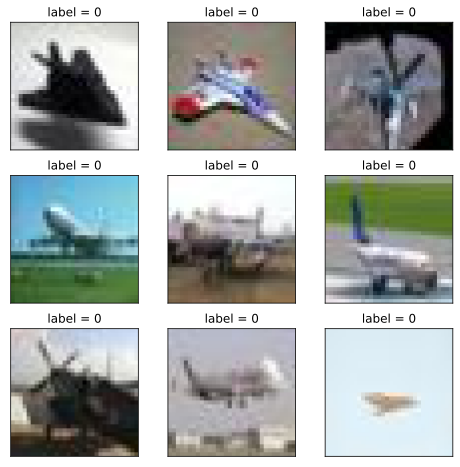

features.shape = torch.Size([50, 3, 32, 32]), 
labels.shape = torch.Size([50, 1])


In [11]:
# 数据读取与查看

# -------------
## transform
# -------------
transform_img = T.Compose([T.ToTensor()])
def transform_label(x):
    return torch.tensor([x]).float()

# -------------
# read data
# -------------
ds_train = datasets.ImageFolder(
    "./data/cifar2/train/",
    transform = transform_img,
    target_transform = transform_label,
)
ds_validate = datasets.ImageFolder(
    "./data/cifar2/test/",
    transform = transform_img,
    target_transform = transform_label,
)
print(f"ds_train.class_to_idx = {ds_train.class_to_idx}")
plot_ds_train(ds_train)
# -------------
# load by dataloader
# -------------
dl_train = DataLoader(ds_train, batch_size = 50, shuffle = True)
dl_validate = DataLoader(ds_validate, batch_size = 50, shuffle = False)
# -------------
# view data
# -------------
# pytorch 图像默认顺序是 (batch, channel, width, height)
for features, labels in dl_train:
    print(f"features.shape = {features.shape}, \nlabels.shape = {labels.shape}")
    break

In [12]:
# 定义模型
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3)
        self.pool = nn.MaxPool2d(kernel_size = 3, stride = 2)
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 5)
        self.dropout = nn.Dropout2d(p = 0.1)
        self.adaptive_pool = nn.AdaptiveMaxPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(64, 32)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = self.adaptive_pool(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout2d(p=0.1, inplace=False)
  (adaptive_pool): AdaptiveMaxPool2d(output_size=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=32, out_features=1, bias=True)
)


In [13]:
# 训练模型

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(net.parameters(), lr = 0.01)
metrics_dict = {
    "acc": Accuracy(),
}

kerasmodel = KerasModel(
    net = net,
    loss_fn = loss_fn,
    optimizer = optimizer,
    metrics_dict = metrics_dict,
)
history_df = kerasmodel.fit(
    train_data = dl_train,
    validate_data = dl_validate,
    epochs = 10,
    ckpt_path = "./torchcheckpoint/checkpoint.pt",
    patience = 5,
    monitor = "val_acc",
    mode = "max",
)

/Users/wangzf/.pyenv/versions/3.7.10/envs/pytorch/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (Accuracy). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
  1%|          | 2/200 [00:00<00:11, 16.70it/s, train_acc=0.42, train_loss=1.21] 


================================================================================2022-08-30 21:27:48
Epoch 1 / 10



100%|██████████| 40/40 [00:01<00:00, 33.58it/s, val_acc=0.8, val_loss=0.457] 
<<<<<< reach best val_acc : 0.8004999756813049 >>>>>>
  1%|          | 2/200 [00:00<00:11, 17.97it/s, train_acc=0.88, train_loss=0.331]


================================================================================2022-08-30 21:28:00
Epoch 2 / 10



100%|██████████| 40/40 [00:01<00:00, 33.62it/s, val_acc=0.872, val_loss=0.306]
<<<<<< reach best val_acc : 0.871999979019165 >>>>>>
  1%|          | 2/200 [00:00<00:11, 17.42it/s, train_acc=0.9, train_loss=0.179] 


================================================================================2022-08-30 21:28:11
Epoch 3 / 10



100%|██████████| 40/40 [00:01<00:00, 33.53it/s, val_acc=0.897, val_loss=0.24] 
<<<<<< reach best val_acc : 0.8970000147819519 >>>>>>
  1%|          | 2/200 [00:00<00:11, 16.55it/s, train_acc=0.94, train_loss=0.19] 


================================================================================2022-08-30 21:28:23
Epoch 4 / 10



  1%|          | 2/200 [00:00<00:11, 16.89it/s, train_acc=0.8, train_loss=0.531] 


================================================================================2022-08-30 21:28:35
Epoch 5 / 10



100%|██████████| 40/40 [00:01<00:00, 34.42it/s, val_acc=0.924, val_loss=0.19] 
<<<<<< reach best val_acc : 0.9235000014305115 >>>>>>
  1%|          | 2/200 [00:00<00:12, 16.45it/s, train_acc=0.94, train_loss=0.132]


================================================================================2022-08-30 21:28:46
Epoch 6 / 10



100%|██████████| 40/40 [00:01<00:00, 34.26it/s, val_acc=0.932, val_loss=0.171]
<<<<<< reach best val_acc : 0.9319999814033508 >>>>>>
  1%|          | 2/200 [00:00<00:10, 18.32it/s, train_acc=0.82, train_loss=0.288]


================================================================================2022-08-30 21:28:58
Epoch 7 / 10



100%|██████████| 40/40 [00:01<00:00, 34.40it/s, val_acc=0.941, val_loss=0.157]
<<<<<< reach best val_acc : 0.940500020980835 >>>>>>
  1%|          | 2/200 [00:00<00:11, 17.21it/s, train_acc=0.98, train_loss=0.0519]


================================================================================2022-08-30 21:29:09
Epoch 8 / 10



  1%|          | 2/200 [00:00<00:10, 18.13it/s, train_acc=0.96, train_loss=0.109]


================================================================================2022-08-30 21:29:20
Epoch 9 / 10



  1%|          | 2/200 [00:00<00:11, 17.41it/s, train_acc=0.9, train_loss=0.366]  


================================================================================2022-08-30 21:29:32
Epoch 10 / 10



100%|██████████| 40/40 [00:01<00:00, 35.09it/s, val_acc=0.943, val_loss=0.151]
<<<<<< reach best val_acc : 0.9434999823570251 >>>>>>


In [14]:
# 模型评估
history_df

,train_loss,train_acc,val_loss,val_acc,epoch
0,0.507214,0.7549,0.457351,0.8005,1
1,0.360619,0.8454,0.306396,0.8720,2
2,0.289943,0.8781,0.240444,0.8970,3
3,0.263154,0.8924,0.266040,0.8910,4
4,0.226269,0.9086,0.190484,0.9235,5
5,0.199061,0.9210,0.171361,0.9320,6
6,0.188763,0.9239,0.157325,0.9405,7
7,0.168847,0.9355,0.170783,0.9290,8
8,0.162990,0.9345,0.173233,0.9395,9
9,0.147698,0.9439,0.150674,0.9435,10


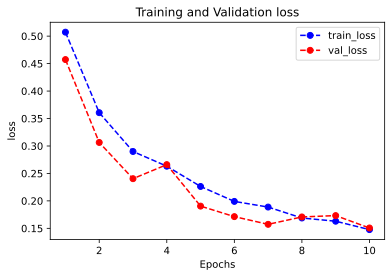

In [15]:
plot_metrics(history_df, "loss")

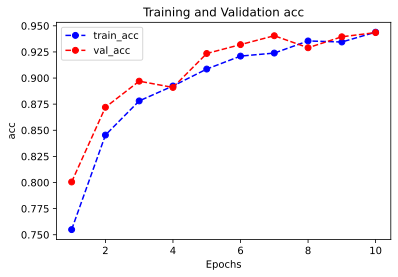

In [16]:
plot_metrics(history_df, "acc")

In [17]:
# 使用模型
## 预测概率
y_pred_probs = kerasmodel.predict(dl_validate)
y_pred_probs

tensor([[-5.9851],
        [-6.6959],
        [-7.2844],
        ...,
        [ 5.2627],
        [11.1310],
        [ 2.3805]])

In [18]:
## 预测类别
y_pred = torch.where(
    y_pred_probs > 0.5,
    torch.ones_like(y_pred_probs),
    torch.zeros_like(y_pred_probs),
)
y_pred

tensor([[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]])

In [19]:
# 保存模型
print(net.state_dict().keys())

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'linear1.weight', 'linear1.bias', 'linear2.weight', 'linear2.bias'])


In [20]:
## 保存模型参数
torch.save(net.state_dict(), "./torchmodels/net_parameter_cifar2.pt")
net_clone = Net()
net_clone.load_state_dict(torch.load("./torchmodels/net_parameter_cifar2.pt"))
kerasmodel.predict(dl_validate)

tensor([[-5.9851],
        [-6.6959],
        [-7.2844],
        ...,
        [ 5.2627],
        [11.1310],
        [ 2.3805]])